In [2]:
import os
import numpy as np
from PIL import Image
from tqdm import tqdm

import pandas as pd

# Pytorch
import torch
torch.manual_seed(29)
from torch import nn
from torch.autograd import Variable
import torch.backends.cudnn as cudnn
import torch.nn.parallel
cudnn.benchmark = True
import torchvision.transforms as transforms

from twrap.utils import model_summary, tensor_to_torch_var
from utils.models import *
from torch.utils.data import DataLoader
from utils.datasets import dataset, test_dataset_visob, TestSampler, test_dataset
from twrap.transform import ToZNorm

from twrap.utils import genROC

from matplotlib import pyplot as plt
plt.rcParams.update({'font.size': 12})

from glob import glob
from sklearn.metrics import roc_curve

from utils.model_utils import genRegionMask



weights_dir = '/media/narsi/LargeData/SP2019/ocularnetv2.1/EX01/weights'

scores_list = [['device', 'visit', 'light_enroll', 'light_verify', 'eye', 'AUC', 'D-prime', 'EER', 'GMR@0.01FMR', 'GMR@0.001FMR']]


In [ ]:
transform=transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize(180),
    transforms.CenterCrop(160),
#     ToZNorm()
    transforms.ToTensor()
    ])

In [ ]:
model = MODEL4(400, classify = False, attention = True, illum_inv=True)
check_point_file = '/media/narsi/LargeData/SP2019/ocularnetv2.1/EX01/weights/MODEL4_VISOB.S1.ALL_EXP02/model_best.pth.tar'
checkpoint = torch.load(check_point_file, map_location=lambda storage, loc: storage)
model.load_state_dict(checkpoint['state_dict'])
model.cuda()
model.eval()
print('.')

In [ ]:
def dprime(targets, scores):
    
    Zt = scores[targets==1]
    Ztm = np.mean(Zt)
    Ztv = np.var(Zt)
    
    Zn = scores[targets==0]
    Znm = np.mean(Zn)
    Znv = np.var(Zn)
    
    d_1 = np.abs(Znm - Ztm)
    d_2 = (0.5 * (Ztv + Znv))**0.5
    
    return d_1/d_2

In [ ]:
device = 'IPHONE'
visit1 = 'EC_VISIT_1'
visit2 = 'EC_VISIT_1'
light_enroll = 'office'
light_verify = 'office'
eye = 'l'

In [ ]:
src_fldr1 = '/media/narsi/fast_drive/CCRops/visob/imgs/'+visit1+'/'+device+'/'+light_enroll
src_fldr2 = '/media/narsi/fast_drive/CCRops/visob/imgs/'+visit2+'/'+device+'/'+light_verify

e_imgs = glob(src_fldr1 + os.sep + 'S1' + os.sep + '*_'+eye+'_*.png')
v_imgs = glob(src_fldr2 + os.sep + 'S2' + os.sep + '*_'+eye+'_*.png')

e_dataset = test_dataset_visob(e_imgs, transform)
v_dataset = test_dataset_visob(v_imgs, transform)

e_dl = DataLoader(e_dataset, num_workers=8, pin_memory=True, batch_sampler = TestSampler(len(e_dataset), 64))
v_dl = DataLoader(v_dataset, num_workers=8, pin_memory=True, batch_sampler = TestSampler(len(v_dataset), 64))

In [ ]:
window_search = []
for x in range(3, 21):
    for y in range(3, 21):
        for ix in range(20-x):
            for jx in range(20-y):
                M = np.float32(np.zeros((1, 1, 1, 20, 20)))
                M[:, :, :, ix:ix+x, jx:jx+y] = 1.0
                M = np.reshape(M, (1, 1, 1, 400))
                M = torch.from_numpy(M).cuda()
                
                model.regions = M#(w = 20, s1 = 13, s2 = 7, s3 = 7, s4 = 2)
                model.regions.data.requires_grad = False
                
                e_feat = []
                e_labels = []
                for (batch_data, batch_target) in tqdm(e_dl):
                    input_var = tensor_to_torch_var(batch_data, True)
                    e_feat.append(model(input_var).data.cpu())
                    e_labels += batch_target
                    del input_var
                e_feat = torch.cat(e_feat, dim = 0)
                e_labels = np.asarray(e_labels, dtype = np.object)
                
                v_feat = []
                v_labels = []
                for (batch_data, batch_target) in tqdm(v_dl):
                    input_var = tensor_to_torch_var(batch_data, True)
                    v_feat.append(model(input_var).data.cpu())
                    v_labels += batch_target
                    del input_var
                v_feat = torch.cat(v_feat, dim = 0)
                v_labels = np.asarray(v_labels, dtype = np.object)
                
                e_feat = e_feat.cuda()
                
                scores = []
                targets = []
                for i in tqdm(range(v_feat.shape[0])):
                    v_f = v_feat[i:i+1, ...].cuda()
                    v_l = v_labels[i]

                    s = F.cosine_similarity(e_feat, v_f).data.cpu().numpy()
                    t = 1 * (e_labels == v_l)
                    scores.append(s)
                    targets.append(t)
                scores = np.concatenate(scores)
                targets = np.concatenate(targets)
                
                dp = dprime(targets, scores)
                
                w_ = [x, y, ix, jx, dp]
                
                window_search.append(w_)
                
                print(w_)
                del M, targets, scores, e_feat, e_labels, v_feat, v_labels
                
                
np.save('window_search_dPrime.npy', np.asarray(window_search))

In [3]:
X = np.load('/home/narsi/local/ocularnetv2.1/window_search_dPrime.npy')

In [18]:
Z = np.zeros((16, 16))

In [19]:
c = 0
for i in range(16):
    for j in range(16):
        Z[i, j] = X[c, -1]
        c += 1

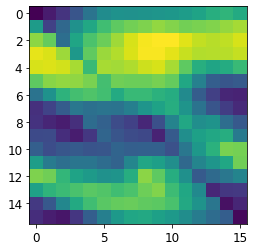

In [20]:
plt.imshow(Z)